<a id="top"></a>
# Query a region, plot an HR diagram, and select a light curve
***

## Prerequisites
Before beginning this tutorial, you should be familiar with: 
- Python syntax, including [for loops](https://www.py4e.com/html3/05-iterations), [conditional expressions](https://www.py4e.com/html3/03-conditional), plotting with [matplotlib](https://matplotlib.org/)
- [astropy tables](https://docs.astropy.org/en/stable/table/index.html)
- [Right Ascension, Declination](https://openstax.org/books/astronomy-2e/pages/4-1-earth-and-sky), and [angular sizes](https://openstax.org/books/astronomy-2e/pages/2-1-the-sky-above)
- [The Hertzsprung-Russell Diagram](https://openstax.org/books/astronomy-2e/pages/18-4-the-h-r-diagram)

## Learning Goals
By the end of this tutorial, you will:

- Query TESS Input Catalog (TIC) data for a region of the sky.
- Plot an interactive HR diagram of a region with Bokeh.
- Plot a lightcurve of a given TIC identifier with lightkurve.

## Introduction

The [Hertzsprung-Russel or HR diagram](https://openstax.org/books/astronomy-2e/pages/18-4-the-h-r-diagram), usually displayed as a color-magnitude diagram, is a powerful tool for astronomers to investigate stellar populations. The many catalogs hosted by MAST contain the information needed to create our own HR diagrams of areas of the sky of our choice. In particular, today we will use the [TESS Input Catalog (or TIC)](https://tess.mit.edu/science/tess-input-catalogue/), which draws information for the [Gaia](https://archive.stsci.edu/missions-and-data/gaia) Data Release 2 catalog as well as a number of other photometric catalogs (such as 2MASS, UCAC4, APASS, SDSS, WISE, and more).

In this tutorial, we will also explore how interactive plotting packages such as [Bokeh](http://bokeh.org/) can enhance our ability to get information from MAST catalogs. In particular, we'll use it plus knowledge of the H-R diagram to identify sources for follow-up investigation of time variability via light curves. 

The workflow for this notebook consists of:
* [Imports](#Imports)
* [Select a region of the sky and query the TESS Input Catalog (TIC)](#Select-a-region-of-the-sky-and-query-the-TESS-Input-Catalog-(TIC))
    * [Exercise 1](#Exercise-1)
* [Create interactive plot with bokeh](#Create-interactive-plot-with-bokeh)
    * [Exercise 2](#Exercise-2)
* [Plot Light Curves of Selected Targets](#Plot-Light-Curves-of-Selected-Targets)
* [Additional Exercises](#Additional-Exercises)

## Imports
- *numpy* to handle array functions
- *matplotlib.pyplot* for plotting data
- *astropy.table Table* for creating tidy tables of the data
- *astropy.coordinates SkyCoord* and *astropy.units* for keeping track of coordinates
- *astroquery.mast Catalogs* and *Observations* for querying the MAST archive
- *bokeh* for interactive potting
- *lightkurve* for searching for and plotting light curves

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

from astroquery.mast import Catalogs
from astroquery.mast import Observations

import bokeh
from bokeh.models.tools import *
from bokeh.plotting import *

import lightkurve as lk

%matplotlib inline

In [2]:
Observations.enable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


## Select a region of the sky and query the TESS Input Catalog (TIC)

Let's first examine a region of the sky we'll choose by coordinate, with a search radius of 1 degree. We're arbitrarily choosing a large patch on the sky to see the overall population of stars that we can find.

In [3]:
# select a region of the sky to query
ra = 180.
dec = +30.
radius=1*u.degree

In [4]:
# convert the coordinates and then query the TIC
coord = SkyCoord(ra, dec, unit="deg")
catalog_data = Catalogs.query_region(coord, radius=radius, catalog="Tic")
catalog_data

ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec
str11,float64,float64,float64,float64,float64,str8,str7,str8,str5,str12,str10,str16,str19,str19,str19,str8,str1,str8,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,int64,float64,str9,str11,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str6,float64,float64,float64,float64,int64,str1,str8,str8,str13,float64,float64,float64,float64,float64,float64,int64,int64,float64
173047667,180.00788,30.003346,5.90936,-1.83599,18.586,STAR,tmgaia,20190415,--,--,--,12000189+3000120,--,J120001.89+300012.6,--,--,--,tmgaia,2.43475,2.43436,tic7,nan,nan,--,195.61669,78.359856,167.071097,27.311945,19.199,0.136,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,16.592,0.118,16.258,0.198,15.295,0.161,BCC-222-111-000-0-0,nan,15.139,0.036,14.839,0.067,12.737,nan,9.007,nan,nan,nan,0.082,gaiaj,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,DWARF,nan,nan,nan,nan,nan,nan,--,nan,--,--,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,--,nan,nan,nan,nan,--,--,--,bpbj,--,4.31222643425527,3.9283332446125,180.007852132136,30.0035172670177,4.31222643425527,3.9283332446125,--,0,27.361171330573335
173047642,179.992764,29.990925,-3.46595,-0.584719,18.346,STAR,tmgaia,20190415,--,--,--,11595826+2959273,--,J115958.24+295927.4,--,--,--,tmgaia,2.36861,2.36814,tic7,nan,nan,--,195.689569,78.349403,167.064181,27.294978,19.762,0.116,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,16.183,0.098,15.627,0.121,15.112,0.135,ABB-222-111-000-0-0,nan,14.439,0.029,14.199,0.044,11.897,nan,8.968,nan,nan,nan,0.07,gaiaj,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,--,nan,DUPLICATE,10000415054,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,--,nan,nan,nan,nan,--,--,--,bpbj,--,3.82924641260637,3.36145497966541,179.992633126404,29.9909623921023,3.82924641260637,3.36145497966541,--,--,39.70279185064992
10000415054,179.992523,29.990965,nan,nan,16.8,EXTENDED,--,20190415,--,--,--,11595820+2959274,1237667211601248455,--,--,--,--,2MASSEXT,nan,nan,--,nan,nan,--,195.69,78.349,167.063951,27.29492,nan,nan,nan,nan,20.526,0.11589,18.585,0.0107531,17.4363,0.00748696,16.9642,0.00787273,16.5889,0.00787273,15.21,nan,14.96,nan,14.235,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.17,tor_j,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,--,nan,--,--,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,--,nan,nan,nan,nan,--,--,--,--,--,nan,nan,nan,nan,nan,nan,--,0,40.01739479173878
954307542,180.008204825263,30.0147927314115,0.699597,-9.27285,20.3835,STAR,gaia2,

As we can see above, this catalog returned a lot of useful columns of data! The full list of columns, their units, and sources are described in the [TIC v8.2 and CTL v8.xx Data Release Notes](https://outerspace.stsci.edu/display/TESS/TIC+v8.2+and+CTL+v8.xx+Data+Release+Notes), the most recent release as of the time of this writing.

Some of the most important ones for our purposes will be:
- ``d`` and ``e_d``, the distance and error, respectively, in parsecs
- ``GAIAmag`` is the Gaia G band magnitude
- ``gaiabp`` and ``gaiarp``, magnitudes from Gaia in the $G_{bp}$ and $G_{rp}$ bands, respectively.

There are also columns for ``Bmag`` and ``Vmag`` (for Johnson B and Johnson V) which can be used to calculate a color index but as you can see from Exercise 1, they are not as well populated as ``gaiabp`` and ``gaiarp``.  

### Exercise 1

What percentage of the returned results have...  
a) ...distance measurements included in the TIC?  
b) ...measurements for ``gaiabp`` *and* ``gaiarp``?   
c) ... measurements for ``Bmag`` *and* ``Vmag``?   

In [5]:
## Write your code for Exercise 1 here.

First, we'll filter out data table to only include rows with distances greater than zero (this will remove any ``nan`` values) and rows whose relative error on the distance is less than 10\%. 

In [6]:
catalog_data = catalog_data[(catalog_data['d'] > 0) & (catalog_data['e_d'] / catalog_data['d'] < 0.1)]

Next, we'll use the appropriate columns to calculate the horizontal and vertical axes of our HR diagram. The horizontal axis is color index, a proxy for temperature. The vertical axis absolute magnitude, calculated using the apparent magnitude and distance.

In [7]:
# calculate the color and absolute magnitude of the star to generate an HR diagram
catalog_data['abs_gaia'] = catalog_data['GAIAmag'] - 5 * np.log10(catalog_data['d'] / 10)
catalog_data['color'] = catalog_data['gaiabp'] - catalog_data['gaiarp']

This is a good way to start investigating H-R diagrams from first principles, but keep in mind that we have not taken into account a number of important considerations, such as [interstellar reddening](https://openstax.org/books/astronomy-2e/pages/20-3-cosmic-dust) or possible binary systems. (According to the documentation, dereddening corrections were applied if the Gaia quality flag is 1.)

As we saw from Exercise 1, some of the rows will be missing data. Let's further narrow down our table to only include rows for which we could successfully calculate color and magnitude.

In [8]:
# Remove NaNs
catalog_data=catalog_data[~np.isnan(catalog_data['color'])]
catalog_data=catalog_data[~np.isnan(catalog_data['abs_gaia'])]

## Create interactive plot with bokeh

We can use tools like `matplotlib` to plot an H-R diagram, but for this tutorial we'll use the package `Bokeh`. First, we need to load Bokeh.

In [9]:
output_notebook()

Loading BokehJS ...

Below, we'll follow the [Bokeh user guide instructions for a basic scatter plot](https://docs.bokeh.org/en/latest/docs/user_guide/basic/scatters.html), with the addition of flipping our vertical exis range to plot the brightness (smallest) magnitudes at the top.

In [10]:
plot_title=str(coord.ra) + ' ' + str(coord.dec)+', radius '+str(radius)

In [11]:
p = figure(title=plot_title, x_axis_label="Gb-Gr",
           y_axis_label="Absolute G")
p.circle(catalog_data['color'],catalog_data['abs_gaia'], alpha=0.6)
p.y_range.flipped = True
show(p)

This looks like a typical H-R diagram! We see the majority of stars along the diagonal main sequence, with the hotter, more luminous stars in the upper left and the cooler, dimmer stars in the lower right. We also see some stars going through the post-main sequence evolution, moving towards the upper right, and possibly even a few stars who have completed their evolution and become white dwarfs (bottom left). 

As we can see, the default Bokeh plot is already very interactive. Using the buttons on the right, we have many options to pan, zoom, save, or reset our figure. Next, we'll do some more advanced Bokeh work by:
- Specifically creating the source dictionary for the plot, which will include the TESS Input Catalog ID number as well as the quantities to plot.
- Defining a Hover Tool that will display all three parts of the dictionary.
- Adding the Hover Tool to the plot

In [12]:
source = ColumnDataSource(
    data=dict(
        x=list(catalog_data['color']),
        y=list(catalog_data['abs_gaia']),
        tic=list(catalog_data['ID'])
    )
)

#source2 = ColumnDataSource(data = dict(x = [], y = [], id =[]))

id_hover_tool = HoverTool(tooltips=[('TIC','@tic'),('Gb-Gr','@x'),('Abs G','@y')])
p = figure(title=plot_title, x_axis_label="Gb-Gr",
           y_axis_label="Absolute G")
p.circle('x', 'y', source=source, alpha=0.6)
p.y_range.flipped = True
p.add_tools(id_hover_tool)
show(p)

### Exercise 2
Using the hover tool, what are the TIC identifiers numbers of stars at the following locations?  
a) (Gb-Gr,G) = (0.865, 0.459)  
b) (Gb-Gr,G) = (1.691, 7.024)  
c) (Gb-Gr,G) = (-0.0288,11.869)  
Confirm your choices by checking the catalog.
Based on their locations in the HR diagram, what type of stars are each of these likely to be?
If you wanted to search for exoplanets orbiting stars, which of the three stars would you investigate further?
If you wanted to examine stellar variability, which of the three stars would you investigate further? 

In [13]:
## Write your code for Exercise 2 here.

## Plot Light Curves of Selected Targets

Let's examine one of the light curves we suspect from above may demonstrate stellar variability. To do this, we'll use the `lightkurve` package to search by TIC ID for light curves, download the results, and plot each one after removing outliers.

In [14]:
search_result=lk.search_lightcurve('TIC 138898766')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 22,2020,QLP,1800,138898766,0.0
1,TESS Sector 49,2022,QLP,600,138898766,0.0


In [15]:
lc_collection=search_result.download_all()
lc_collection

LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 138898766" SECTOR=22 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    1: <TessLightCurve LABEL="TIC 138898766" SECTOR=49 AUTHOR=QLP FLUX_ORIGIN=sap_flux>

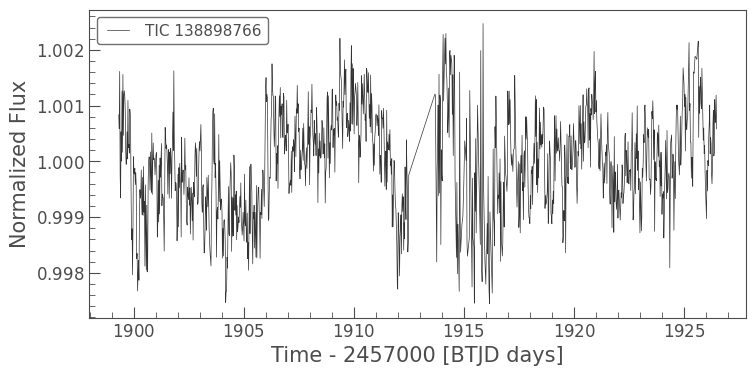

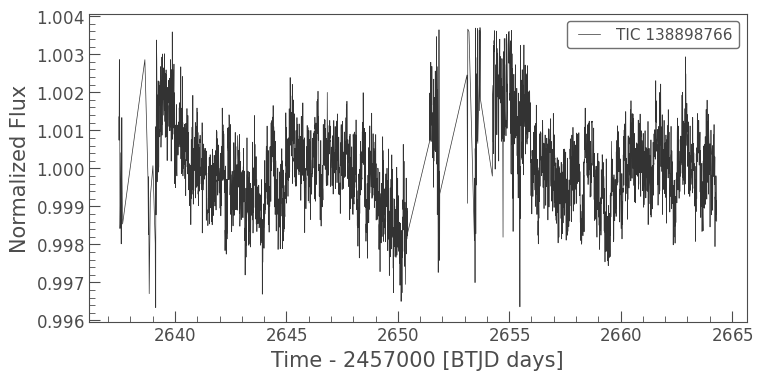

In [16]:
# Plotting all together can sometimes be hard to read if they are separated by a large amount of time.
for lc in lc_collection:
    lc=lc.remove_outliers(sigma=3.0)
    lc.plot()

This looks promising! There are a lot of other steps we might take to assure we have a high-quality light curve and then analyze it for periodicity. Check out some of the other TIKEBook tutorials to learn about some of these topics.
- [01-lightcurves](../../notebooks/01-lightcurves)
- [02-quality-flags](../../notebooks/02-quality-flags)
- [03-asteroseismology](../../notebooks/03-asteroseismology)

## Additional Exercises

3. Determine how many rows in `catalog_data` have lightcurves available in the MAST archive. This can take a while! To speed up the process, just focus on those targets that have absolute G magnitude < 6. (Keep in mind, we can also create new [lightcurves from target pixel files](https://docs.lightkurve.org/tutorials/1-getting-started/plotting-target-pixel-files.html).)

4. Choose one of the target stars that is on the main sequence and plot its lightcurve. This time, since we are looking for possible exoplanets, don't remove the 3-sigma outliers. Ideally, you can use one you already identified has having a light curve in Exercise 3. Analyze what you see. Are there obvious signs of a transiting exoplanet, stellar variability, or instrumental effects?

5. Plot the HR diagrams of the NGC2362 and M67 star clusters, on the same plot. Qualitatively, which cluster is older? How do you know? More details: You'll want to look up information about the angular size of each cluster, in order to choose a correct search radius. Also make sure to only include search results in the correct distance range. On your plot, represent the clusters with two different colors and shapes. Include a plot legend.


## Additional Resources

- [Gaia Data Release 2: Observational Hertzsprung-Russell diagrams](https://www.aanda.org/articles/aa/full_html/2018/08/aa32843-18/aa32843-18.html), Gaia Collaboration, 2018, A&A Vol 616
- [Age determination for 269 Gaia DR2 open clusters](https://www.aanda.org/articles/aa/full_html/2019/03/aa34693-18/aa34693-18.html), Bossini et al. 2019, A&A Vol 623

## Citations

If you use `astropy` or `lightkurve` for published research, please cite the
authors. Follow these links for more information about citing:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* [Citing MAST missions](https://archive.stsci.edu/publishing/mission-acknowledgements)

## About this Notebook
For support, contact `archive@stsci.edu`.

**Author(s):** Ryan Oelkers, Julia Kamenetzky <br>
**Keyword(s):** Tutorial, HR diagram, interactive, light curve <br>
**Last Updated:** Sep 2022 <br>
**Next Review:** Apr 2023
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 